The purpose of the project is this course is for you to show what you have learnt. It is a bit more free that the assignments, we want you to show us that you can use Python to investigate a dataset. 

In [912]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
%matplotlib inline


We are going to look at a different type of data, which is based on words, in this case song lyrics. 

Since the algorithms that we have seen all take as input some form of numerical vector, we will need to turn the words into numerical vectors. There are a few ways to do this, but the one we are going to use is call a Bag of Words. The reason for calling it a Bag is to suggest that the order of the words doesn't matter, just their frequency. Essentially, it counts how often each word gets used in each piece of text, and then the counts form the input vector. These counts are often normalised by the number of words in the text, since otherwise longer pieces get higher scores than short ones. 

The dataset we are going to use is a set of song lyrics. There is a zip file on Blackboard containing the lyrics of 80 songs (that Rolling Stone magazine decided were the most amazing songs there are) called `rs_lyrics.zip`. Download it and unzip it. It will make a folder called `rs_lyrics` with the songs inside. The following code will then read then in, and store the songtitle and lyrics in a dataframe.

In [913]:
import os
df = pd.DataFrame(columns = ["Name","Lyrics"])
i=0
for filename in os.listdir('rs_lyrics'):
   with open(os.path.join('rs_lyrics', filename), 'r') as f:
        df.loc[i] =[filename[:-4], f.read().splitlines()]
        df["Lyrics"][i] = " ".join(df["Lyrics"][i])
        i+=1
df.head()

,Name,Lyrics
0,1999,I was dreamin' when I wrote this Forgive me if...
1,all_apologies,What else should I be All apologies What else ...
2,anarchy_in_the_uk,I am an antichrist uh I am an anarchist Don't ...
3,a_day_in_the_life,I read the news today oh boy About a lucky man...
4,back_in_black,Back in black I hit the sack I've been too lon...


We have to do a lot of work before we can cluster word data. As the length of the vector is the number of different words in all of the texts, it can end up as a very long vector. So we want to 
- remove the unimportant words
- remove the short words
- remove the punctuation
- make everything lower-case, so that "Love" and "love" are the same word.

There are various ways doing all of these, but they aren't too hard to write yourself. To get single words in lower case from a string called `text` use `text.lower().strip().split()`
That sorts out the last of those four aims for us. 

For the third one, you can use `translate` from the `string` module. Use `import string` and then:
`text = text.translate(str.maketrans('', '', string.punctuation))`

You should also use `text = text.translate(str.maketrans('','','(1)'))` and the same for (2) to get rid of some text that is in those files that isn't helpful for us.

In [914]:
import string
shortlist = []
for i in range(len(df)):
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('','','(1)'))
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('','','(2)'))
    df["Lyrics"][i] = df["Lyrics"][i].translate(str.maketrans('', '', string.punctuation))

Now we need to write a function that deletes any word that is not important. 

How do you decide if a word in important? One way is to ask somebody. Linguists have a list of them, which they call stopwords. I've downloaded a list of stopwords from the web that is on Blackboards (`stopwords.txt`). Download it and load it using:

`with open('../Datasets/stopwords.txt', 'r') as f:
    stopwords = f.read().splitlines()`
    
Then all you need to do is return only the words that are not in that list. One way to do that is with the function below. 


In [915]:
def removeWords(text, removeList):
    return [word for word in text.lower().strip().split() if word not in removeList]

In [916]:
with open ("stopWords.txt", "r") as myfile:
    stopWords=myfile.read().split('\n')
stopWords[:5]

['a', 'about', 'above', 'across', 'after']

## Task 1

Use the function above to (1) remove the stopwords, and (2) remove any words that are less than 3 characters long (so words like 'a' or 'to'). One way to do this is to write a function that returns just the words that are more than two characters long. Another is to make a function that finds any words of 2 characters or less and puts those in a list (you can see them in the output below), and then calls removeWords() with that list. (4 marks)

In [917]:
df["Lyrics"] = df["Lyrics"].apply(lambda x: removeWords(x, stopWords))
df["Lyrics"]


0     [dreamin, wrote, forgive, goes, astray, woke, ...
1     [apologies, say, gay, write, dont, right, apol...
2     [antichrist, uh, anarchist, dont, know, want, ...
3     [read, news, today, oh, boy, lucky, man, grade...
4     [black, hit, sack, ive, long, im, glad, yes, i...
                            ...                        
75    [hey, mama, dont, treat, wrong, come, love, da...
76    [mother, mother, theres, crying, brother, brot...
77    [dig, picture, engaged, kiss, sweat, body, cov...
78    [stone, set, eyes, thorn, twist, wait, sleight...
79    [yesterday, troubles, far, away, looks, theyre...
Name: Lyrics, Length: 80, dtype: object

In [918]:
df["Lyrics"] = df["Lyrics"].apply(lambda x: " ".join(list(filter(lambda y : len(y)>2, x))))

In [919]:
df.head()

,Name,Lyrics
0,1999,dreamin wrote forgive goes astray woke mornin ...
1,all_apologies,apologies say gay write dont right apologies s...
2,anarchy_in_the_uk,antichrist anarchist dont know want know wanna...
3,a_day_in_the_life,read news today boy lucky man grade news sad j...
4,back_in_black,black hit sack ive long glad yes let loose noo...


Once you have processed the data using those functions the top of your dataframe should look like this:

In [920]:
df.head()

,Name,Lyrics
0,1999,dreamin wrote forgive goes astray woke mornin ...
1,all_apologies,apologies say gay write dont right apologies s...
2,anarchy_in_the_uk,antichrist anarchist dont know want know wanna...
3,a_day_in_the_life,read news today boy lucky man grade news sad j...
4,back_in_black,black hit sack ive long glad yes let loose noo...


The next thing we need to do is to get the counts. Again, we could do this by hand, but it taks a long time to run if you don't have efficient code. 
## Task 2
Look up the `TfidVectorizer` in sklearn, and work out how to use it on the Lyrics column (it uses the standard `name.fit_transform` approach in sklearn, you might also want to use `name.get_feature_names()`). Store the counts of each song in a new dataframe called counts. The output below shows the counts vectors of the 5 most common words. The columns are the 80 songs. (4 marks)

In [921]:

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Lyrics"])
names = vectorizer.get_feature_names_out()
counts = pd.DataFrame(X.toarray(), columns = names)
counts

,abandoned,aches,achieve,act,actin,admit,adore,advice,affection,afraid,...,years,yes,yesterday,youd,youll,young,younger,youre,youve,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.015648,0.000000,0.280243
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.594666,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.042982,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.081244,0.038934,0.000000
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [922]:

counts.T.nlargest(5, 0)

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
party,0.732132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
nineteen,0.280243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ninety,0.280243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zero,0.280243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oops,0.153347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [923]:
counts.T.loc["need"].sort_values(ascending=False)

53    0.326337
27    0.140890
42    0.113821
23    0.101900
79    0.092533
        ...   
29    0.000000
26    0.000000
24    0.000000
22    0.000000
40    0.000000
Name: need, Length: 80, dtype: float64

# Task 3
Use PCA to plot the positions of the songs in 2D using the counts vectors. It isn't so informative yet, since we don't have any information about clusters in the data. (3 marks)

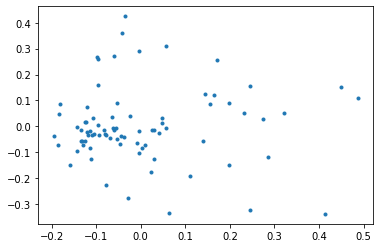

In [924]:
pca = PCA(2)
coordinates = pca.fit_transform(counts)
plt.plot(coordinates[:,0], coordinates[:,1], '.')
plt.show()

## Task 4
The next thing to do is to try and cluster the songs together according to their count vectors. You can use any algorithm you like, but I recommend $k$-means. For now, just pick an arbitrary number of clusters (I used 4), but make sure you can cluster the data. Take a look at the songs inside a cluster and see if you think they have any similarities. (4 marks)

In [925]:
kmeans = KMeans(n_clusters=4, random_state = 0).fit(coordinates)
kmeans_pred = kmeans.predict(coordinates)


We need to do some more work to work out how many clusters there are. To do this we will take is to see which words are the most common in each cluster. If the cluster is good, then we would expect to see quite a few words in common between the songs in the cluster. There is a function below (`get_top_features_cluster`) that finds them if you give it predictions make by the $k$-means algorithm and the number of words you want. 

## Task 5
Work out how to use the algorithm on the output from $k$-means, and then plot the bar charts for the different clusters. (`df.plot.bar()` will plot things from a Pandas dataframe). You should also use the PCA data and plot the points in different colours according to the clusters kmeans has found. Use both of these resources to decide how many clusters there are in the data.Explain your answer. (7 marks)

In [926]:
def get_top_features_cluster(counts, prediction, nfeatures):
    labels = np.unique(prediction)
    df1 = []
    for label in labels:
        inds = np.where(prediction==label) 
        means = np.mean(counts[inds], axis = 0) 
        sorted_means = np.argsort(means)[::-1][:nfeatures] 
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], means[i]) for i in sorted_means]
        newdf = pd.DataFrame(best_features, columns = ['features', 'score'])
        df1.append(newdf)
    return df1

In [927]:
def plot_clusters(df, num):
    for i in range(num):
        fig = plt.figure(figsize=(6,5))
        plt.bar(df[i]["features"], df[i]["score"])
        plt.xlabel("Features")
        plt.xticks(rotation=90)
        plt.show()

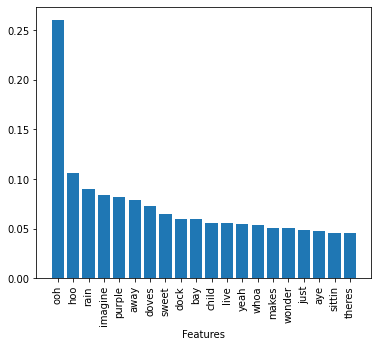

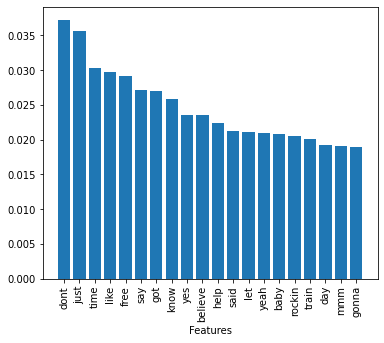

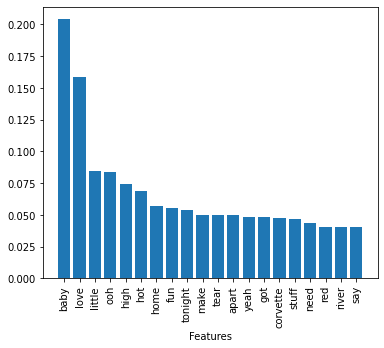

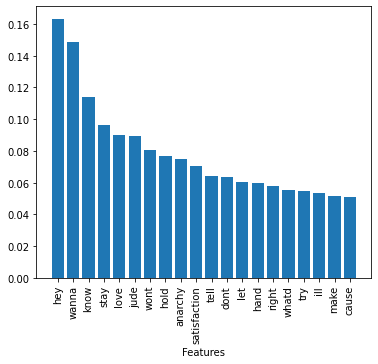

In [928]:
plot_clusters(get_top_features_cluster(counts.to_numpy(), kmeans_pred, 20), 4)

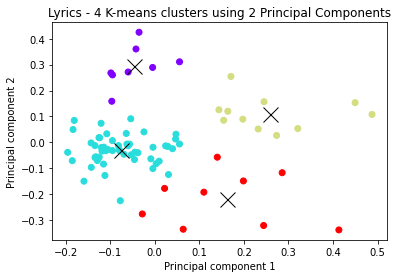

In [999]:
# use the PCA data and plot the points in different 
# colours according to the clusters kmeans has found
plt.scatter(coordinates[:,0], coordinates[:,1], c=kmeans_pred, cmap='rainbow')
for i in range (4):
    plt.plot(kmeans.cluster_centers_[i,0],kmeans.cluster_centers_[i,1],'kx',markersize=15)
plt.title("Lyrics - 4 K-means clusters using 2 Principal Components")
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")
plt.show()


* Use both of these resources to decide how many clusters there are in the data.Explain your answer. (7 marks)

4 clusters seems to be an appropriate number of clusters for this data. It could potentially vary quite a lot, the red data is quite sparse, which makes it less clear if this is a valid cluster. The last 2 cluster involve lots of love lyrics and the first 2 have weighting toward rocking. Potentially there are only a couple of clusters here.

## Task 6
Repeat this analysis on the dataset of national anthems that is available on Blackboard as `anthems.csv` and comment on the differences in words and clusters. This dataset includes the continent that the country is on. Does using this variable change your clusters? (8 marks)

In [930]:
data = pd.read_csv("anthems.csv", encoding = 'utf-8')
data.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


Use the function above to (1) remove the stopwords, and (2) remove any words that are less than 3 characters long (so words like 'a' or 'to'). One way to do this is to write a function that returns just the words that are more than two characters long. Another is to make a function that finds any words of 2 characters or less and puts those in a list (you can see them in the output below), and then calls removeWords() with that list. (4 marks)

In [931]:
def removePunctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

In [932]:
def removeShortMakeLower(text):
    return [word for word in text.lower().strip().split() if len(word)>2]

In [933]:
data["Anthem"] = data["Anthem"].apply(lambda x: " ".join(removeWords(x, stopWords))).apply(lambda x: removePunctuation(x)).apply(lambda x : " ".join(removeShortMakeLower(x)))
data["Anthem"]

0      flag stand united wish goal sacred oath bestow...
1      fatherland free independent centuries lived su...
2      land mountains land river land fields land cat...
3      azerbaijan azerbaijan glorious fatherland valo...
4      belarusians peaceful people wholeheartedly dev...
                             ...                        
185    defenders homeland rally glory time blood surg...
186    uganda god uphold thee lay future thy hand uni...
187    sons sahara battlefield torch holders long roa...
188    stand sing zambia proud free land work joy uni...
189    lift high banner flag zimbabwe symbol freedom ...
Name: Anthem, Length: 190, dtype: object

### Vectorize Task 6

In [934]:
vectorizer = TfidfVectorizer()
X2 = vectorizer.fit_transform(data["Anthem"])
names2 = vectorizer.get_feature_names_out()
counts2 = pd.DataFrame(X2.toarray(), columns = names2)
counts2

,4th,abandon,abandons,abanyarwanda,abide,ablaze,able,abound,abounds,above,...,zeal,zealand,zealous,zenith,zimbabwe,zion,ºciuszko,ãƒârpãƒâ,œending,šawice
0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.097557,0.0
4,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
186,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
187,0.0,0.09894,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
188,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


### PCA Task 6

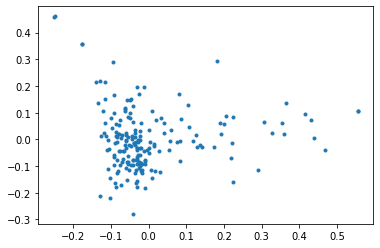

In [935]:
pca = PCA(2)
coordinates2 = pca.fit_transform(counts2)
plt.plot(coordinates2[:,0], coordinates2[:,1], '.')
plt.show()

In [936]:
kmeans2 = KMeans(n_clusters=4, random_state = 0).fit(coordinates2)
kmeans2_pred = kmeans2.predict(coordinates2)


### Task 6 Frequency of words within Clusters

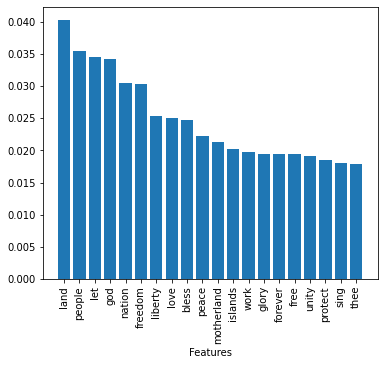

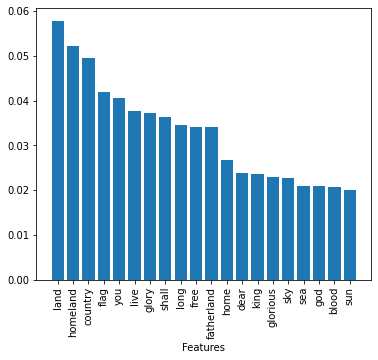

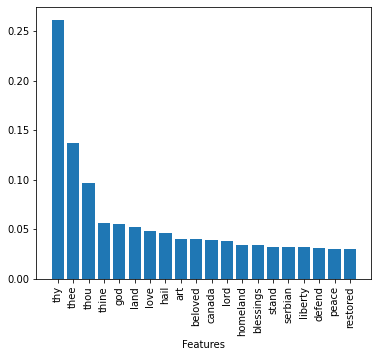

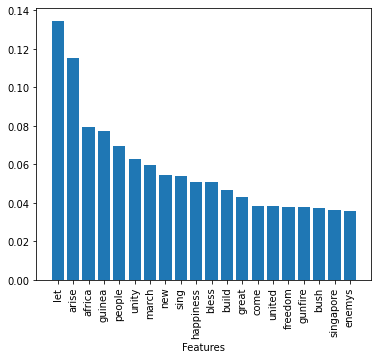

In [937]:
plot_clusters(get_top_features_cluster(counts2.to_numpy(), kmeans2_pred, 20), 4)

### Pre-Continent Addition clustering with 2 PCs

In [997]:
def plot_kmeans_2pc(x_y, k, title):
    k_means = KMeans(n_clusters=k, random_state = 0).fit(x_y)
    k_means_pred = k_means.predict(x_y)
    plt.scatter(x_y[:,0], x_y[:,1], c=k_means_pred, cmap='rainbow')
    for i in range (k):
        plt.plot(k_means.cluster_centers_[i,0],k_means.cluster_centers_[i,1],'kx',markersize=15)
    plt.title(title + " - " + str(k) + " clusters using 2 PC")
    plt.xlabel("Principal component 1")
    plt.ylabel("Principal component 2")
    plt.show()


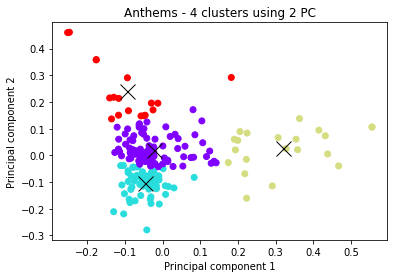

In [998]:
plot_kmeans_2pc(coordinates2, 4, "Anthems")

In [971]:
def elbow(x_y, kmax):
    distortions = []
    for k in range(2, kmax):
        k_means = KMeans(n_clusters=k, random_state = 0).fit(x_y)
        distortions.append(k_means.inertia_)
    plt.plot(range(2, kmax), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title("Elbow curve for Anthem data")
    plt.show()

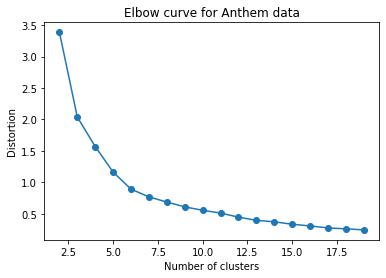

In [972]:
elbow(coordinates2, 20)

The Elbow plot shows that the optimal number of clusters should be roughly 5 or 6 at the elbow of the plot. 


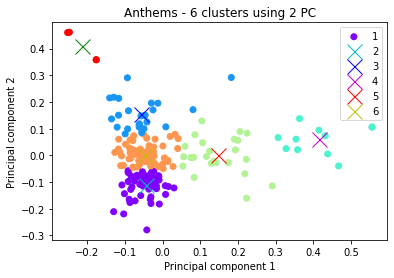

In [976]:
plot_kmeans_2pc(coordinates2, 6, "Anthems")

The split of the clusters seem relatively abitrary, it is quite difficult to validate this.

### Post-Continent addition clustering with 2 PCs


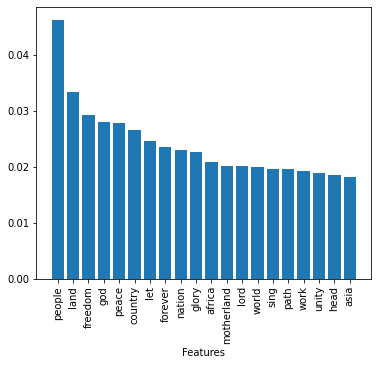

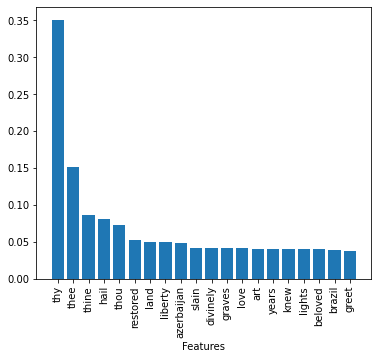

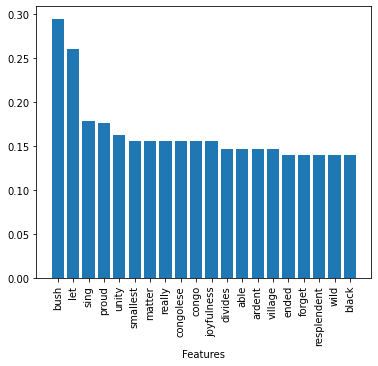

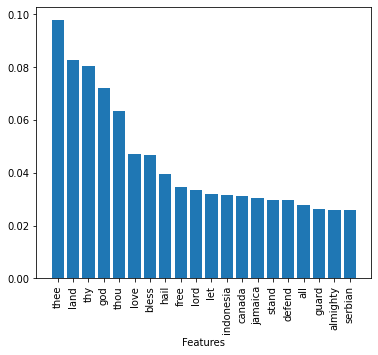

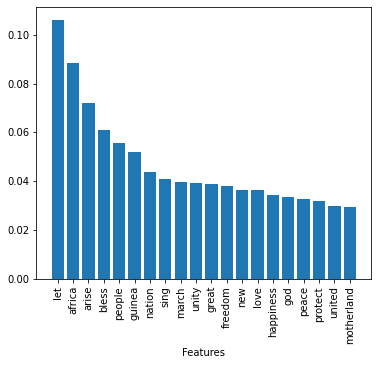

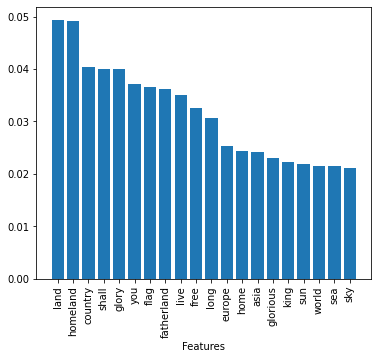

In [977]:
anthem_continent = data["Continent"] + " " + data["Anthem"]
X3 = vectorizer.fit_transform(anthem_continent)
names3 = vectorizer.get_feature_names_out()
counts3 = pd.DataFrame(X3.toarray(), columns = names3)
coordinates3 = pca.fit_transform(counts3)
k_means = KMeans(n_clusters=6, random_state = 0).fit(coordinates3)
k_means_pred = k_means.predict(coordinates3)
plot_clusters(get_top_features_cluster(counts3.to_numpy(), k_means_pred, 20), 6)

'Thy' and 'Land' are common among multiple clusters.

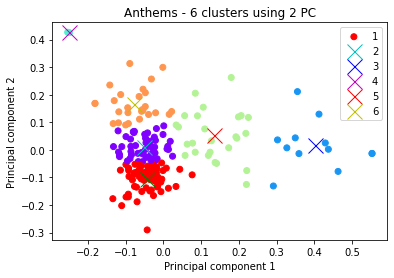

In [978]:
plot_kmeans_2pc(coordinates3, 6, "Anthems")

After adding the continents to the vectorizer, there appears to be a very small cluster in the top left hand corner. It is difficult to tell if these are outliers or a very small group cluster.

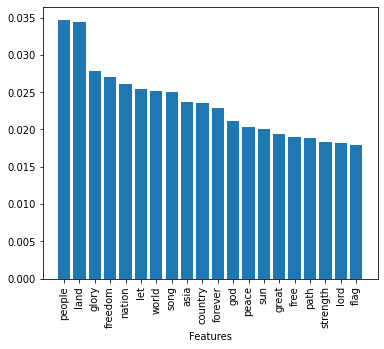

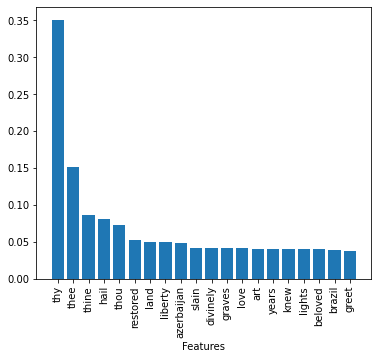

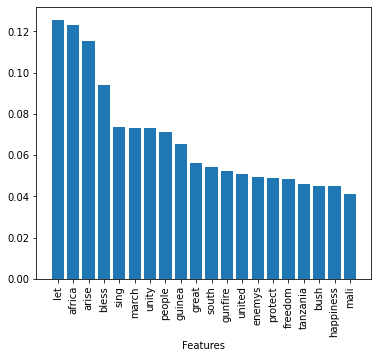

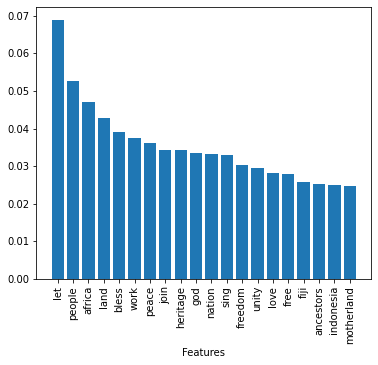

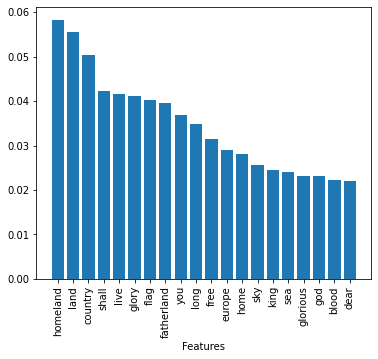

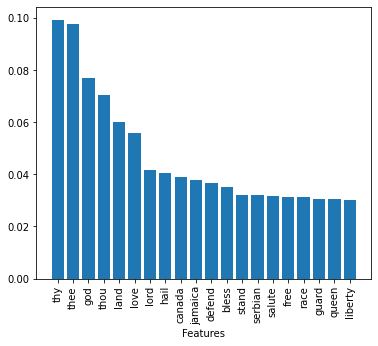

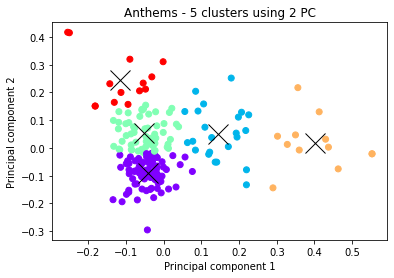

In [945]:
plot_clusters(get_top_features_cluster(counts3.to_numpy(), k_means_pred, 20), 6)
plot_kmeans_2pc(coordinates3, 5, "Anthems")

When taking into account only 5 clusters, the top left group gets merged with the closest group and there are some slight differences within the middle groups. Overall, the continents appeared to have a minor affect on the result when add to the vectorizer as another lyric. The fact that there are country names in the Anthem's may make these cluster similarly clustered based off continent.